In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

In [32]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


In [3]:
temp.tail()

,date,avg,min,max
3282,2019-12-27,-1.7,-4.6,2.6
3283,2019-12-28,1.1,-3.6,6.1
3284,2019-12-29,3.8,1.1,6.2
3285,2019-12-30,2.7,-5.7,6.8
3286,2019-12-31,-7.9,-10.9,-4.5


In [4]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [5]:
temp.index[(3287-(365*2))]

2557

<class 'pandas.core.frame.DataFrame'>


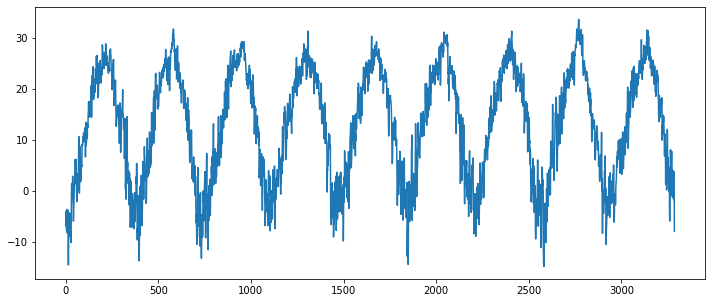

In [33]:
temp_data=temp[['avg']]
print(type(temp_data))
plt.figure(figsize=(12,5))
plt.plot(temp_data)
plt.show()

In [34]:
scaler = MinMaxScaler(feature_range=(-1,1))
temp_data = scaler.fit_transform(temp_data)
print(type(temp_data))

<class 'numpy.ndarray'>


In [28]:
train = temp_data[:2557]
test = temp_data[2557:]
print(type(train))

<class 'numpy.ndarray'>


In [9]:
def create_dataset(time_data, look_back=1): # look_back = 주기
  data_X, data_y = [],[]

  for i in range(len(time_data)-look_back):
    data_X.append(time_data[i:(i+look_back)])  # 행에만 해당, 열은 적지 않았으니.
    data_y.append(time_data[i+look_back])

  print('data.shape', np.shape(data_X), np.shape(data_y))
  return np.array(data_X), np.array(data_y)

In [10]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X, test_y = create_dataset(test, look_back)

print(train.shape, test.shape)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

data.shape (2377, 180, 1) (2377, 1)
data.shape (550, 180, 1) (550, 1)
(2557, 1) (730, 1)
(2377, 180, 1) (2377, 1) (550, 180, 1) (550, 1)


In [11]:
2377/11

216.0909090909091

In [12]:
model=Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(None,1))))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
Hist = model.fit(train_X, train_y, epochs=200, batch_size=216, validation_data=(test_X, test_y))

Epoch 1/200
12/12 [==============================] - 35s 134ms/step - loss: 0.1113 - val_loss: 0.0268
Epoch 2/200
12/12 [==============================] - 0s 29ms/step - loss: 0.0261 - val_loss: 0.0157
Epoch 3/200
12/12 [==============================] - 0s 29ms/step - loss: 0.0177 - val_loss: 0.0174
Epoch 4/200
12/12 [==============================] - 0s 29ms/step - loss: 0.0173 - val_loss: 0.0160
Epoch 5/200
12/12 [==============================] - 0s 29ms/step - loss: 0.0162 - val_loss: 0.0158
Epoch 6/200
12/12 [==============================] - 0s 28ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 7/200
12/12 [==============================] - 0s 29ms/step - loss: 0.0166 - val_loss: 0.0154
Epoch 8/200
12/12 [==============================] - 0s 29ms/step - loss: 0.0175 - val_loss: 0.0153
Epoch 9/200
12/12 [==============================] - 0s 29ms/step - loss: 0.0157 - val_loss: 0.0148
Epoch 10/200
12/12 [==============================] - 0s 29ms/step - loss: 0.0169 - val_loss: 0.01

In [14]:
trainScore = model.evaluate(train_X, train_y, verbose=0)
print('Train Score:', trainScore)

testScore = model.evaluate(test_X, test_y, verbose=0)
print('Test Score:', testScore)

Train Score: 0.00867096520960331
Test Score: 0.008649292401969433


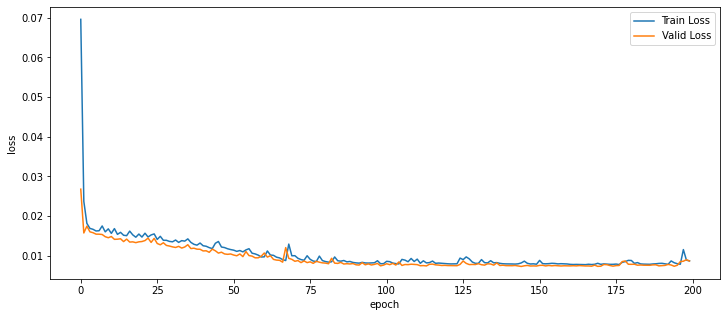

In [16]:
plt.figure(figsize=(12,5))
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

xhat.shape: (180, 1) type(xhat): <class 'numpy.ndarray'>
type(a): <class 'numpy.ndarray'> a.shape: (1, 180, 1)


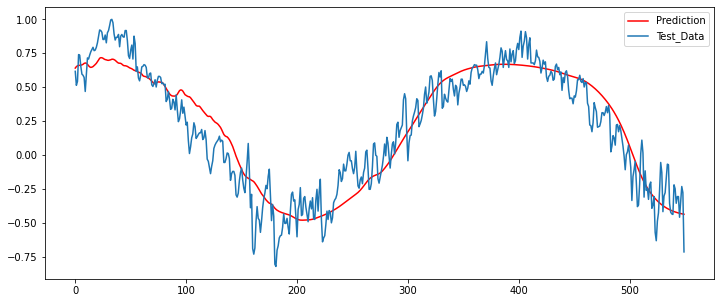

In [42]:
look_ahead=550

xhat=test_X[0]                                           # (550,180,1) 인 형태를 -> (180,1) -> 550개 (1,180, 1)로??? model.predict를 위해 인풋이 3차원. 한줄씩 예측값 생성
print('xhat.shape:',xhat.shape,'type(xhat):',type(xhat))

a= np.array([xhat])                                      # 이미 array인 xhat를 -> 리스트-> array??
print('type(a):',type(a), 'a.shape:',a.shape)

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead): # 550번 반복
  prediction = model.predict(np.array([xhat]), batch_size=1)  # len(prediction) = 1, prediction.shape = (1,1)
  predictions[i] = prediction  # prediction = y값
  xhat = np.vstack([xhat[1:], prediction]) # 원래 가지고 있던 첫번째줄을 삭제하면서 뒤에 prediction값을 하나씩 추가

plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label='Test_Data')
plt.legend()
plt.show()



xhat.shape: (180, 1) type(xhat): <class 'numpy.ndarray'>
type(a): <class 'numpy.ndarray'> a.shape: (1, 180, 1)


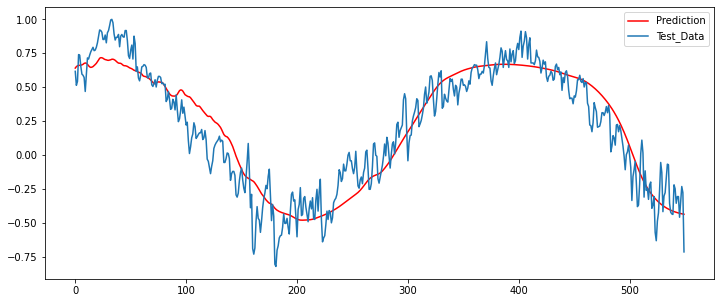

In [43]:
look_ahead=550

xhat=test_X[0]                                           # (550,180,1) 인 형태를 -> (180,1) -> 550개 (1,180, 1)로??? model.predict를 위해 인풋이 3차원. 한줄씩 예측값 생성
print('xhat.shape:',xhat.shape,'type(xhat):',type(xhat))

a= np.array([xhat])                                      # 이미 array인 xhat를 -> 리스트-> array??
print('type(a):',type(a), 'a.shape:',a.shape)

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead): # 550번 반복
  prediction = model.predict(np.array([xhat]), batch_size=1)  # len(prediction) = 1, prediction.shape = (1,1)
  predictions[i] = prediction  # prediction = y값
  xhat = np.vstack([xhat[1:], prediction]) # 원래 가지고 있던 첫번째줄을 삭제하면서 뒤에 prediction값을 하나씩 추가

plt.figure(figsize=(12,5))
plt.plot(predictions, 'r', label='Prediction')  #np.arange 넣지 않아도 똑같은 값..
plt.plot(test_y[:look_ahead], label='Test_Data')
plt.legend()
plt.show()

